In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
path = '../../datasets/lfw'

In [3]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


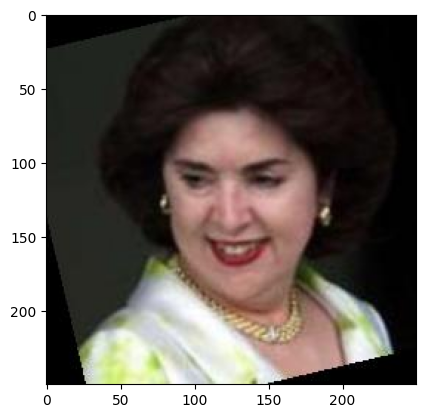

In [5]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function. 

In terms of **Applications** :  
- AutoEncoders are often applied in tasks such as compression and reconstruction of data, denoising, anomaly detection, dimensionality reduction
- In the case of Variational AutoEncoders,they are often used for generative modeling (generate new content), data compressopn, detect anomalies, removing noise, synthetic data creation

In terms of **Architecture** : 
- AEs architecure has two parts, an encoder which compresses the input data into lower dimension space and a decoder which reconstructs the output as similar as possible to the input from lower dimension space to output space.
- For VAEs, the encoder transforms the input data into the parameters of a probability distribution within the latent space. The encoder outputs the mean and the log-variance of a Gaussian distribution representing the latent space. The decoder then samples from this distribution to generate data.

In terms of **Loss function**:
- AEs generally are using the Mean Squared Error loss function to measure the difference between the input and the reconstructed outpu in order to reconstruct the data.
- But VAEs loss function is generally a combination of KL-divergence a regularization loss which minimizes the difference between a supposed distribution and original distribution of dataset and of MSE loss function (called reconstruction loss) in our case for image data. Therefore, the total loss is the sum of the regularization loss and the reconstruction loss

*Sources :*
- *[Variational AutoEncoders](https://www.geeksforgeeks.org/variational-autoencoders/)*
- *[What is a variational autoencoder (VAE)?](https://www.techtarget.com/searchenterpriseai/definition/variational-autoencoder-VAE)*
- *[What are Autoencoders? Applcations and Use cases](https://www.analyticsvidhya.com/blog/2023/05/unleashing-the-power-of-autoencoders-applications-and-use-cases/#h-applications-of-autoencoder)*
- *[7 Applications of Auto-Encoders every Data Scientist should know](https://towardsdatascience.com/6-applications-of-auto-encoders-every-data-scientist-should-know-dc703cbc892b)*

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [88]:
#As the tutorial I'll take back the same architecture as the previous assignment
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE,self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1),  # 64, 125, 125
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # 64, 63, 63
            nn.Conv2d(64, 128, 3, stride=2),  # 128, 32, 32
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2),  # 64, 63, 63
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, stride=2),  # 3, 126, 126
            nn.ReLU(True),
            nn.ConvTranspose2d(3, 3, 4, stride=2),  # 3, 25, 252
            nn.Sigmoid()
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)
       
    def forward(self, x):
        h   = self.encoder(x)
        out = self.decoder(h)
        return out
       

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

In [89]:
# Instantiate the VAE model
model = VAE()

for x, y in dataloader:
    # As the previous block of code in Step 1, we will take the first data
    sample_data = x[0]
    break
    
# Pass the input image through the VAE model
output_image = model(sample_data)

# Print the shapes of encoder and decoder outputs
encoderOutput = model.encode(output_image)
decoderOutput = model.decode(encoderOutput)
print("Encoder output shape:", encoderOutput.shape)
print("Decoder output shape:", decoderOutput.shape)


Encoder output shape: torch.Size([128, 30, 30])
Decoder output shape: torch.Size([3, 250, 250])


**how would you generate new samples in the latent space**  

To generate new sample in the latent space, we need to sample from the learned distribution of the latent variables. For VAEs, the latent space is modeled as a Gaussian distribution parameterized by mean $\mu$ and log variance $log(\sigma^{2})$ as explained previously.  
To draw a sample from a normal distribution with mean $\mu$ and standard deviation $\sigma$ we need the following formula :  
$$ z=\mu + (exp(\frac{1}{2} \times log(\sigma^{2})) \bigodot  \epsilon $$  
  
With :
- $z$ the sampled latent vector.
- $\mu$ the mean vector obtained from the encoder.
- $\epsilon$ a random sample from a standard normal distribution.

By sampling process we can explore the latent space by generating new latent vectors that can be decoded by the decoder to produce novel samples. By varying $\mu$ and $\sigma$ 
σ during sampling, we can traverse different regions of the latent space, generating diverse outp  
We will generate z during the forward propagation. And once z generated, we can pass it through the decoder to generate new samples in the data space.uts.

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


In [90]:
#Print the total number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters in the model:", total_params)

Total number of parameters in the model: 152662


We will use Mean Squared error as the reconstruction loss because we are working with image data. and the KL divergence loss as the regularization function as explained during the step 2. To implement the KL divergence loss we will, during the forward propagation with the following formula :
$$\sum_{i=1}^{m} \sigma^{2}_{i} + \mu^{2}_{i} + log(\sigma_{i}) - 1 $$

* create an optimizer for training

In [91]:
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [92]:
loss_function = nn.MSELoss()

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

**I tried to modify my model architecture but I still have the same error.**

In [102]:
num_epochs = 5
for epoch in range(num_epochs):
    total_loss = 0
    for data in dataloader:
        img, y = data
        
        # ===================forward=====================
        
        param_f = model.encode(img)
        mu_f, logvar_f = param_f.split(param_f.size(1)//2, 1)
        kl = - 0.5 * (1 + logvar_f - mu_f.pow(2) - logvar_f.exp())  #Calculation of KL divergence loss
        kl_loss = kl.sum() / img.size(0)
        std_f = torch.exp(0.5 * logvar_f)

        z = torch.randn_like(mu_f) * std_f + mu_f 
        print(z.shape)
        output = model.decode(z)
        fit = 0.5 * (output - input).pow(2) 
        fit_loss = fit.sum() / input.size(0)
        loss = kl_loss + fit_loss
        
        loss = criterion(output, img) #Total loss is the sum of KL and MSE
        
        # ===================backward====================
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.data
        
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, total_loss))

torch.Size([32, 64, 30, 30])


RuntimeError: Given transposed=1, weight of size [128, 64, 3, 3], expected input[32, 64, 30, 30] to have 128 channels, but got 64 channels instead

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

In [ ]:
# Take a random image from the dataset
for x, y in dataloader:
    original_img = x[2]
    break

# Pass the original image through the autoencoder
with torch.no_grad():
    reconstructed_img = model(original_img)  # Add batch dimension
    param_f = model.encoder(random_image.unsqueeze(0))
    mu_f, logvar_f = param_f.split(param_f.size(1)//2, 1)
    std_f = torch.exp(0.5 * logvar_f)
    z = torch.randn_like(mu_f) * std_f + mu_f
    generated_samples = model.decoder(z)

# Plot the original and generated images
plt.subplot(1, 2, 1)
plt.imshow(original_img_np)
plt.title("Original Image")

plt.subplot(1, 2, 2) #In order to have the plot next to each other
plt.imshow(generated_samples)
plt.title("Generated Image")

plt.show()

plt.imshow()